In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [8]:
movies_df=pd.read_csv('movies.csv')
movies_df.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [10]:
ratings=pd.read_csv('ratings.dat',sep='::', header=None, engine='python')
ratings.columns = ['userid', 'movieid', 'rating', 'timestamp']
ratings.head(2)

,userid,movieid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109


In [12]:
ratings.userid=ratings.userid.astype(str).astype(int)
ratings.movieid=ratings.movieid.astype(str).astype(int)
ratings.rating=ratings.rating.astype(str).astype(int)
ratings.timestamp = pd.to_datetime(ratings.timestamp.astype(int), unit='s')
ratings.head()

,userid,movieid,rating,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [13]:
n_users=ratings.userid.unique().shape[0]
n_movies=ratings.movieid.unique().shape[0]
n_ratings=len(ratings)
avg_rpu=n_ratings/n_users

In [15]:
print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_rpu)

Number of unique users:  6040
Number of unique movies:  3706
Number of total ratings:  1000209
Average number of ratings per user:  165.5975165562914


In [16]:
movieIndex=ratings.groupby("movieid").count().sort_values(by="rating",ascending=False)[0:1000].index
ratings2=ratings[ratings.movieid.isin(movieIndex)]
ratings.count()

userid       1000209
movieid      1000209
rating       1000209
timestamp    1000209
dtype: int64

In [23]:
userIndex = ratings2.groupby("userid").count().sort_values(by="rating",ascending=False).sample(n=1000, random_state=2018).index
ratings3 = ratings2[ratings2.userid.isin(userIndex)]
ratings3.count()

userid       123412
movieid      123412
rating       123412
timestamp    123412
dtype: int64

In [33]:
movies=ratings3.movieid.unique()
moviesdf=pd.DataFrame(data=movies,columns=['originalmovieid'])
moviesdf['newmovieid']=moviesdf.index+1

users = ratings3.userid.unique()
usersdf = pd.DataFrame(data=users,columns=['originaluserid'])
usersdf['newuserid'] = usersdf.index+1
ratingdf = ratings3.merge(moviesdf,left_on='movieid',right_on='originalmovieid')
ratingdf.drop(labels='originalmovieid', axis=1, inplace=True)

ratingdf = ratingdf.merge(usersdf,left_on='userid',right_on='originaluserid')
ratingdf.drop(labels='originaluserid', axis=1, inplace=True)

ratingdf.head()

,userid,movieid,rating,timestamp,newmovieid,newuserid
0,5,2987,4,2000-12-31 06:12:50,1,1
1,5,2333,4,2000-12-31 06:03:27,2,1
2,5,1175,5,2000-12-31 06:39:19,3,1
3,5,39,3,2000-12-31 06:43:57,4,1
4,5,288,2,2000-12-31 07:09:45,5,1


In [35]:
n_users = ratingdf.userid.unique().shape[0]
n_movies = ratingdf.movieid.unique().shape[0]
n_ratings = len(ratingdf)
avg_rpu = n_ratings/n_users
print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_rpu)

Number of unique users:  1000
Number of unique movies:  1000
Number of total ratings:  123412
Average number of ratings per user:  123.412


In [36]:
X_train, X_test = train_test_split(ratingdf, test_size=0.10, shuffle=True, random_state=2018)
X_validation, X_test = train_test_split(X_test, test_size=0.50, shuffle=True, random_state=2018)

In [37]:
print('Size of train set: ', len(X_train))
print('Size of validation set: ', len(X_validation))
print('Size of test set: ', len(X_test))


Size of train set:  111070
Size of validation set:  6171
Size of test set:  6171


In [38]:
ratings_train = np.zeros((n_users,n_movies))
for row in X_train.itertuples():
    ratings_train[row[6]-1, row[5]-1] = row[3]
ratings_train.shape

(1000, 1000)

In [41]:
sparsity = float(len(ratings_train.nonzero()[0]))
sparsity /= (ratings_train.shape[0] * ratings_train.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 11.11%


In [42]:
ratings_validation = np.zeros((n_users, n_movies))
for row in X_validation.itertuples():
    ratings_validation[row[6]-1, row[5]-1] = row[3]

In [43]:
ratings_test = np.zeros((n_users, n_movies))
for row in X_test.itertuples():
    ratings_test[row[6]-1, row[5]-1] = row[3]

In [44]:
sparsity = float(len(ratings_validation.nonzero()[0]))
sparsity /= (ratings_validation.shape[0] * ratings_validation.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 0.62%


# #class defined for rbm(no changes needed)

In [45]:
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)

    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.placeholder(tf.float32, [self._output_size])
        _vb = tf.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        v0 = tf.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), self.batchsize),range(self.batchsize,len(X), self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list

    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)

In [47]:
inputX = ratings_train
inputX = inputX.astype(np.float32)
rbm=RBM(1000,1000,0.3,500,200)


In [49]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
err = rbm.train(inputX)
outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Use `tf.cast` instead.
Epoch: 0 reconstruction error: 1.544130
Epoch: 1 reconstruction error: 1.515652
Epoch: 2 reconstruction error: 1.559923
Epoch: 3 reconstruction error: 1.547246
Epoch: 4 reconstruction error: 1.569579
Epoch: 5 reconstruction error: 1.554372
Epoch: 6 reconstruction error: 1.565810
Epoch: 7 reconstruction error: 1.556943
Epoch: 8 reconstruction error: 1.563134
Epoch: 9 reconstruction error: 1.557803
Epoch: 10 reconstruction error: 1.558281
Epoch: 11 reconstruction error: 1.557807
Epoch: 12 reconstruction error: 1.559115
Epoch: 13 reconstruction error: 1.552938
Epoch: 14 reconstruction error: 1.562446
Epoch: 15 reconstruction error: 1.550799
Epoch: 16 reconstruction error: 1.556363
Epoch: 17 reconstruction error: 1.563549
Epoch: 18 reconstruction error: 1.557671
Epoch: 19 reconstruction error: 1.553960
Epoch: 20 reconstruction error: 1.557511
Epoch: 21 reco

Epoch: 185 reconstruction error: 1.562601
Epoch: 186 reconstruction error: 1.552789
Epoch: 187 reconstruction error: 1.556691
Epoch: 188 reconstruction error: 1.547333
Epoch: 189 reconstruction error: 1.551858
Epoch: 190 reconstruction error: 1.551369
Epoch: 191 reconstruction error: 1.553573
Epoch: 192 reconstruction error: 1.549582
Epoch: 193 reconstruction error: 1.555014
Epoch: 194 reconstruction error: 1.551621
Epoch: 195 reconstruction error: 1.557055
Epoch: 196 reconstruction error: 1.543045
Epoch: 197 reconstruction error: 1.555147
Epoch: 198 reconstruction error: 1.547934
Epoch: 199 reconstruction error: 1.551271
Epoch: 200 reconstruction error: 1.552242
Epoch: 201 reconstruction error: 1.551816
Epoch: 202 reconstruction error: 1.555195
Epoch: 203 reconstruction error: 1.556545
Epoch: 204 reconstruction error: 1.549355
Epoch: 205 reconstruction error: 1.556520
Epoch: 206 reconstruction error: 1.549202
Epoch: 207 reconstruction error: 1.554744
Epoch: 208 reconstruction error: 1

Epoch: 381 reconstruction error: 1.558142
Epoch: 382 reconstruction error: 1.560190
Epoch: 383 reconstruction error: 1.562039
Epoch: 384 reconstruction error: 1.552693
Epoch: 385 reconstruction error: 1.558172
Epoch: 386 reconstruction error: 1.561121
Epoch: 387 reconstruction error: 1.557726
Epoch: 388 reconstruction error: 1.557750
Epoch: 389 reconstruction error: 1.555449
Epoch: 390 reconstruction error: 1.556299
Epoch: 391 reconstruction error: 1.561481
Epoch: 392 reconstruction error: 1.557855
Epoch: 393 reconstruction error: 1.551504
Epoch: 394 reconstruction error: 1.555229
Epoch: 395 reconstruction error: 1.560455
Epoch: 396 reconstruction error: 1.557239
Epoch: 397 reconstruction error: 1.557816
Epoch: 398 reconstruction error: 1.557827
Epoch: 399 reconstruction error: 1.560539
Epoch: 400 reconstruction error: 1.561004
Epoch: 401 reconstruction error: 1.559951
Epoch: 402 reconstruction error: 1.559419
Epoch: 403 reconstruction error: 1.554814
Epoch: 404 reconstruction error: 1

Text(0, 0.5, 'Reconstruction Error')

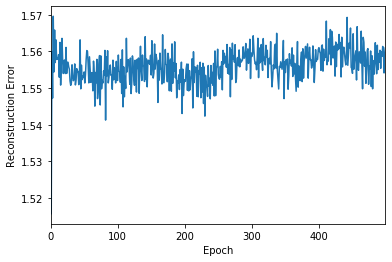

In [50]:
pd.Series(err).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")

In [51]:
inputValidation = ratings_validation
inputValidation = inputValidation.astype(np.float32)
finalOutput_validation, reconstructedOutput_validation, _ = rbm.rbm_output(inputValidation)

In [52]:
predictionsArray = reconstructedOutput_validation
pred_validation = predictionsArray[ratings_validation.nonzero()].flatten()
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()
rbm_prediction = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using RBM prediction:', rbm_prediction)

Mean squared error using RBM prediction: 10.064819316156214
